In [ ]:
# Installing required packages
!pip install pyspark
!pip install findspark


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

##  Load the data


In [ ]:
spark = SparkSession \
    .builder \
    .appName("clustering") \
    .getOrCreate()


In [ ]:
sqlContext = SQLContext(spark)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Select input data

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving drybeans.csv to drybeans.csv
Saving ch9 (1).pptx to ch9 (1).pptx


In [ ]:
file='drybeans.csv'

df = sqlContext.read.load(file,
                          format='com.databricks.spark.csv',
                          header='true',inferSchema='true')

In [ ]:
df.count()

13611

In [ ]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Area,13611,53048.284549261625,29324.09571688207,20420,254616
Perimeter,13611,855.2834585996654,214.28969589196151,524.736,1985.37
MajorAxisLength,13611,320.1418673032194,85.6941859593335,183.601165,738.8601535
MinorAxisLength,13611,202.2707140828817,44.97009129411471,122.5126535,460.1984968
AspectRation,13611,1.5832419790188144,0.24667845568580432,1.024867596,2.430306447
Eccentricity,13611,0.750894929372346,0.09200176320620888,0.218951263,0.911422968
ConvexArea,13611,53768.20020571596,29774.915817000012,20684,263261
EquivDiameter,13611,253.06421992490445,59.17712014871156,161.2437642,569.3743583
Extent,13611,0.7497327873564055,0.049086366843964224,0.555314717,0.866194641


In [ ]:
df = df.drop('Class')

# Prepare the features

In [ ]:
from pyspark.ml.feature import VectorAssembler
featuresUsed = df.columns

assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features")
assembled = assembler.transform(df)

# Choose number of cluster of Kmean

In [ ]:
#elbow point
number_of_clusters = 5

In [ ]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k = number_of_clusters)

In [ ]:
model = kmeans.fit(assembled)

# Make prediction and show evaluation

In [ ]:
predictions = model.transform(assembled)

In [ ]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  520|
|         2| 3705|
|         0| 9386|
+----------+-----+



In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
cost = evaluator.evaluate(predictions)

In [ ]:
print(cost)

0.8262409265056134


In [ ]:
centers = model.clusterCenters()

In [ ]:
print(centers)

[array([3.94039515e+04, 7.41889991e+02, 2.75634793e+02, 1.81986018e+02,
       1.52297286e+00, 7.27881819e-01, 3.98756457e+04, 2.22868176e+02,
       7.50491938e-01, 9.88235576e-01, 8.95448863e-01, 8.15862914e-01,
       7.09631058e-03, 1.98013503e-03, 6.69379158e-01, 9.96264469e-01]), array([1.73708006e+05, 1.58682284e+03, 5.93746342e+02, 3.74494358e+02,
       1.58663498e+00, 7.71053829e-01, 1.76040635e+05, 4.69270023e+02,
       7.76670114e-01, 9.86888965e-01, 8.64297508e-01, 7.92303935e-01,
       3.44074408e-03, 8.42278487e-04, 6.28664768e-01, 9.91829684e-01]), array([7.06792305e+04, 1.03987472e+03, 3.94492493e+02, 2.29486871e+02,
       1.73544755e+00, 8.06365490e-01, 7.18016281e+04, 2.99216191e+02,
       7.44028928e-01, 9.84410220e-01, 8.18386308e-01, 7.60393312e-01,
       5.65239335e-03, 1.16929205e-03, 5.80352903e-01, 9.92474222e-01])]


In [ ]:
elbowset = assembled.select("features")
elbowset.persist()

DataFrame[features: vector]

# Data validation to find the best K

In [ ]:
import numpy as np
# Evaluate clustering by computing Silhouette score

cost = np.zeros(30)
for k in range(2,31):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1)

    model = kmeans.fit(elbowset)
    prediction=model.transform(elbowset)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(prediction)
    cost[k-1] = silhouette

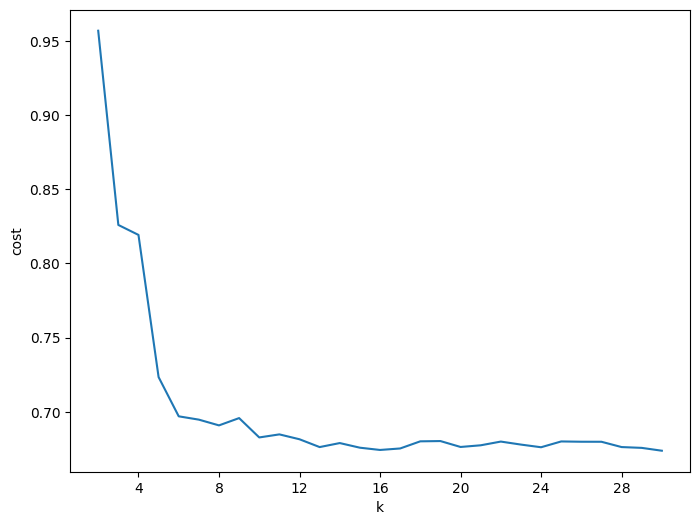

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,31),cost[1:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Scale the input data with 0 mean unit(1) variance

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="features_std", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [ ]:
kmean = KMeans(k = number_of_clusters,featuresCol="features_std")

In [ ]:
model_std = kmean.fit(scaledData)

In [ ]:
prediction_std = model_std.transform(scaledData)


In [ ]:
prediction_std.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  524|
|         2| 5507|
|         0| 7580|
+----------+-----+



In [ ]:
evaluator = ClusteringEvaluator()
cost = evaluator.evaluate(prediction_std)
print(cost)

0.6375313166565078


## Perform elbow plot in the range of 2 - 31

In [ ]:
elbowset = scaledData.select("features_std")
elbowset.persist()

DataFrame[features_std: vector]

In [ ]:
# Evaluate clustering by computing Silhouette score
cost = np.zeros(30)
for k in range(2,31):
    kmeans = KMeans(featuresCol="features_std")\
            .setK(k)\
            .setSeed(1)

    model = kmeans.fit(elbowset)
    prediction=model.transform(elbowset)
    evaluator = ClusteringEvaluator(featuresCol="features_std")
    silhouette = evaluator.evaluate(prediction)
    cost[k-1] = silhouette

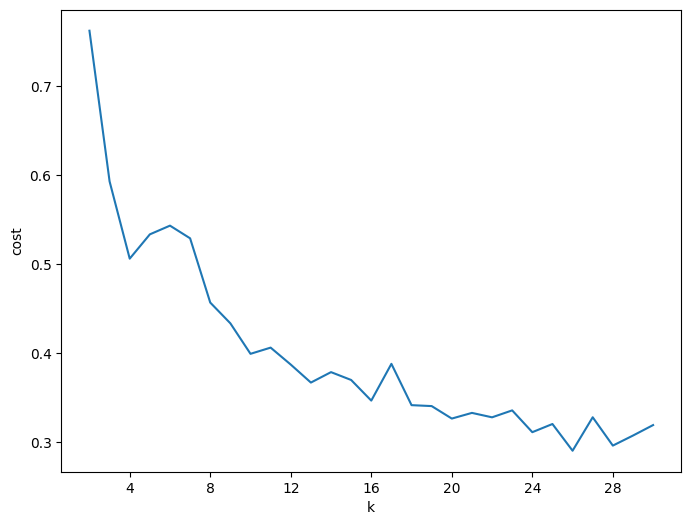

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,31),cost[1:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

หลัง scale จะได้ผลลัพธ์ที่ดีกว่า

In [ ]:
spark.stop()